# Example on how to configure a case using mom6-tools

This is a very simple example showing how to read `diag_config.yaml`, create a case instance, compute a climatology and visualize the results.

In [18]:
from mom6_tools.DiagsCase import DiagsCase
import yaml
import xarray as xr
import matplotlib
from mom6_tools import m6toolbox
%matplotlib inline

In [7]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [8]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])

In [9]:
dcase.casename

'g.c2b6.GJRA.TL319_t061.long_JRA_mct.025'

In [10]:
# Load the grid
grd = dcase.grid

MOM6 grid successfully loaded... 



In [19]:
parallel, cluster, client = m6toolbox.request_workers(6)

Requesting 6 workers... 

/proxy/8787/status


In [21]:
RUNDIR = dcase.get_value('RUNDIR')

%time ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.sfc_*.nc', \
         parallel=True, data_vars='minimal', chunks={'time': 12},\
         coords='minimal', compat='override')

CPU times: user 7.42 s, sys: 827 ms, total: 8.25 s
Wall time: 2min 26s


In [22]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 21900, xh: 540, xq: 540, yh: 458, yq: 458)
Coordinates:
  * yq            (yq) float64 -79.14 -79.01 -78.89 -78.76 ... 87.68 87.73 87.74
  * yh            (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.64 87.71 87.74
  * nv            (nv) float64 1.0 2.0
  * xq            (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * xh            (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * time          (time) object 0001-01-01 12:00:00 ... 0060-12-31 12:00:00
Data variables:
    SSH           (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    tos           (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    sos           (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    SSU           (time, yh, xq) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    SSV           (time, yq, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    mass_wt       (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    opottempmint  (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    somint        (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    Rd_dx         (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    speed         (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    mlotst        (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    oml           (time, yh, xh) float32 dask.array<chunksize=(12, 458, 540), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    time_bnds     (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    filename:          g.c2b6.GJRA.TL319_t061.long_JRA_mct.025.mom6.sfc_0001.nc
    title:             MOM6 diagnostic fields table for CESM case: g.c2b6.GJR...
    associated_files:  area_t: g.c2b6.GJRA.TL319_t061.long_JRA_mct.025.mom6.s...
    grid_type:         regular
    grid_tile:         N/A

In [ ]:
# Plot 5-yearly average sst
sst = ds['tos'].mean('time').load()

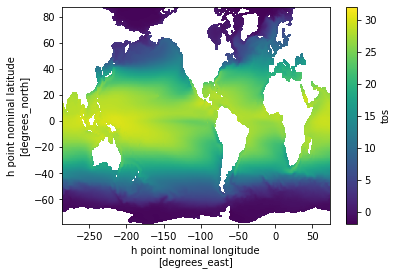

In [26]:
sst.plot(vmin=-2, vmax=32)